In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F


test 1-3 are duplicated runs with the same random seed

In [2]:
emb1 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test1_rd_0_base.npy'))
lambdas1 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test1_rd_0_base.csv')
emb2 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test2_rd_0_base.npy'))
lambdas2 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test2_rd_0_base.csv')
emb3 = torch.from_numpy(np.load('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test3_rd_0_base.npy'))
lambdas3 = pd.read_csv('/hpc/group/naderilab/eleanor/Efficient_PLM/prose/ALLY/saved_emb/test3_rd_0_base.csv')

print(f'test1: shape of emb: {emb1.shape}, shape of lambdas: {lambdas1.shape}')
print(f'test2 shape of emb: {emb2.shape}, shape of lambdas: {lambdas2.shape}')
print(f'test3: shape of emb: {emb3.shape}, shape of lambdas: {lambdas3.shape}')

data = [(emb1, lambdas1), (emb2, lambdas2), (emb3, lambdas3)]

test1: shape of emb: torch.Size([49078, 512]), shape of lambdas: (49078, 1)
test2 shape of emb: torch.Size([49078, 512]), shape of lambdas: (49078, 1)
test3: shape of emb: torch.Size([49078, 512]), shape of lambdas: (49078, 1)


In [3]:
class lambdaset(Dataset):
    def __init__(self, X_train, X_test, y_train, y_test, train=True):

        if train:
            self.x_data, self.y_data = X_train, y_train
        else:
            self.x_data, self.y_data = X_test, y_test
    
    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i], i

    def __len__(self):
        return self.y_data.shape[0]

In [4]:
# Regression model
class RegressionHead(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(),

            nn.Linear(256, 16),
            nn.LeakyReLU(),

            nn.Linear(16, 1),
            nn.Softplus()  # non-negative lambda, sigmoid + cross entropy loss + clip = True?
        )
    
    def forward(self, x):
        return self.model(x)

In [5]:
# Regression model - # non-negative lambda according to min-max transformation of target variable -> sigmoid + clip
class RegressionHead2(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.clip_min = 1e-4
        self.clip_max = 1
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),

            nn.Linear(256, 16),
            nn.ReLU(),

            nn.Linear(16, 1),
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        x = torch.clamp(x, min=self.clip_min, max=self.clip_max)
        return x

In [7]:
dic_train = {}
dic_val = {}

for run in range(0, 3):
    X = data[run][0]
    y = torch.tensor(data[run][1].values, dtype=torch.float32)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1357)
    scaler = MinMaxScaler()
    y_train = scaler.fit_transform(y_train.reshape(-1, 1)) 
    y_test = scaler.transform(y_test.reshape(-1, 1)) 
    
    train_loader = DataLoader(lambdaset(X_train, X_test, y_train, y_test, train = True), batch_size=128, shuffle=True, drop_last=True)
    val_loader = DataLoader(lambdaset(X_train, X_test, y_train, y_test, train = False), batch_size=128, shuffle=True, drop_last=True)
    
    model = RegressionHead(input_dim=X.shape[1])
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3) 
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.95)
    
    
    # train and validation mse per batch
    train_mse_ls = []
    val_mse_ls = [] 
    
    # cross entropy loss??
    
    # Training loop
    print(f'Run{run+1}')
    for epoch in range(100):
        model.train()
        total_loss = 0
        train_iterator = iter(train_loader)
        mse = []
        print_every = 10
        for j in range(len(train_loader)):
            x, y, i = next(train_iterator)
            optimizer.zero_grad()
            preds = model(x).squeeze()
            loss = criterion(preds, y.squeeze().float())
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            mse.append(mean_squared_error(y.squeeze().numpy(), preds.detach().numpy()))
        scheduler.step()
    
        batch_mse = sum(mse) / len(mse)    
        train_mse_ls.append(batch_mse)
            
        # model.eval()
        # val_iterator = iter(val_loader)
        # val_mse = 0
        # with torch.no_grad():
        #     for k in range(len(val_loader)):
        #         x, y, i = next(val_iterator)
        #         pred = model(x).squeeze()
        #         val_mse += F.mse_los(pred.squeeze(), y.squeeze())
        #         # val_mse += mean_squared_error(pred.squeeze(), y.squeeze())
        #     val_mse_ls.append(val_mse/len(val_loader))
            # y_pred = model(X_test).squeeze().cpu().numpy()
            # val_mse = mean_squared_error(y_pred, y_test)
            # val_mse_ls.append(val_mse)

        model.eval()
        with torch.no_grad():
            y_pred = model(X_test).squeeze().cpu().numpy()
            val_mse = mean_squared_error(y_pred, y_test)
            val_mse_ls.append(val_mse)
            
        
        if epoch % print_every == 0:
            print(f"Epoch {epoch+1} | training MSE: {batch_mse:.6f} | validation MSE: {val_mse:.6f}") # mse on transformed scale
    dic_train['run'+str(run+1)] = train_mse_ls
    dic_val['run'+str(run+1)] = val_mse_ls

Run1
Epoch 1 | training MSE: 0.011130 | validation MSE: 0.007067
Epoch 11 | training MSE: 0.007352 | validation MSE: 0.006929
Epoch 21 | training MSE: 0.007222 | validation MSE: 0.006838
Epoch 31 | training MSE: 0.007098 | validation MSE: 0.006677
Epoch 41 | training MSE: 0.006933 | validation MSE: 0.006703
Epoch 51 | training MSE: 0.006868 | validation MSE: 0.006543
Epoch 61 | training MSE: 0.006822 | validation MSE: 0.006559
Epoch 71 | training MSE: 0.006809 | validation MSE: 0.006509
Epoch 81 | training MSE: 0.006788 | validation MSE: 0.006494
Epoch 91 | training MSE: 0.006771 | validation MSE: 0.006522
Run2
Epoch 1 | training MSE: 0.012598 | validation MSE: 0.007933
Epoch 11 | training MSE: 0.007672 | validation MSE: 0.007360
Epoch 21 | training MSE: 0.007488 | validation MSE: 0.007071
Epoch 31 | training MSE: 0.007295 | validation MSE: 0.007007
Epoch 41 | training MSE: 0.007210 | validation MSE: 0.006973
Epoch 51 | training MSE: 0.007133 | validation MSE: 0.006785
Epoch 61 | train

In [ ]:
# dic_train = {}
# dic_val = {}

# for run in range(0, 3):
#     X = data[run][0]
#     y = torch.tensor(data[run][1].values, dtype=torch.float32)
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     scaler = MinMaxScaler()
#     y_train = scaler.fit_transform(y_train.reshape(-1, 1)) # 0 - 1
    
#     train_loader = DataLoader(lambdaset(X_train, X_test, y_train, y_test, train = True), batch_size=128, shuffle=True, drop_last=True)
#     val_loader = DataLoader(lambdaset(X_train, X_test, y_train, y_test, train = False), batch_size=128, shuffle=True, drop_last=True)
    
#     model = RegressionHead2(input_dim=X.shape[1])
    
#     # Loss and optimizer
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=1e-3) 
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.95)
#     y_test = scaler.transform(y_test) # if sth greater than 1
    
#     # train and validation mse per batch
#     train_mse_ls = []
#     val_mse_ls = [] 
    
#     # cross entropy loss??
    
#     # Training loop
#     print(f'Run{run+1}')
#     for epoch in range(100):
#         model.train()
#         total_loss = 0
#         iterator = iter(train_loader)
#         mse = []
#         print_every = 10
#         for i in range(len(train_loader)):
#             x, y, i = next(iterator)
#             optimizer.zero_grad()
#             preds = model(x).squeeze()
#             loss = criterion(preds, y.squeeze().float())
#             loss.backward()
#             optimizer.step()
            
#             total_loss += loss.item()
#             mse.append(mean_squared_error(y.squeeze().numpy(), preds.detach().numpy()))
#         scheduler.step()
    
#         batch_mse = sum(mse) / len(mse)    
#         train_mse_ls.append(batch_mse)
            
#         model.eval()
#         with torch.no_grad():
#             y_pred = model(X_test).squeeze().cpu().numpy()
#             val_mse = mean_squared_error(y_pred, y_test)
#             val_mse_ls.append(val_mse)
            
    
#         if epoch % print_every == 0:
#             print(f"Epoch {epoch+1} | training MSE: {batch_mse:.6f} | testing MSE: {val_mse:.6f}") # mse on transformed scale
#     dic_train['run'+str(run+1)] = train_mse_ls
#     dic_val['run'+str(run+1)] = val_mse_ls

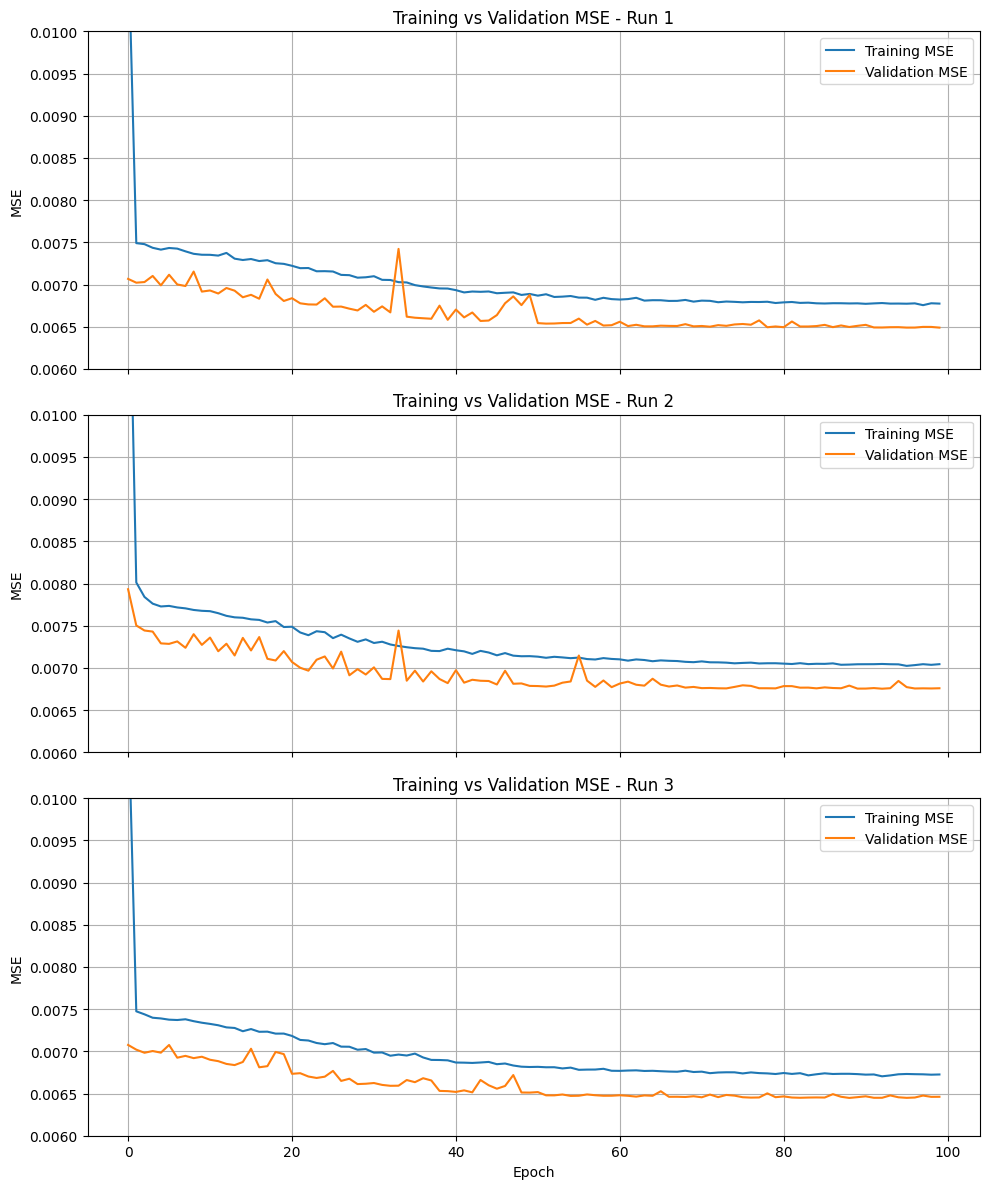

In [8]:
import matplotlib.pyplot as plt

epochs = range(100)

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for i in range(3):
    axes[i].plot(epochs, dic_train['run'+str(i+1)], label='Training MSE')
    axes[i].plot(epochs, dic_val['run'+str(i+1)], label='Validation MSE')
    axes[i].set_ylabel('MSE')
    axes[i].set_ylim(0.0060, 0.0100)
    axes[i].set_title(f'Training vs Validation MSE - Run {i+1}')
    axes[i].legend()
    axes[i].grid(True)

axes[2].set_xlabel('Epoch')

plt.tight_layout()
plt.show()

In [ ]:
(len(y_pred_held) - np.count_nonzero(y_pred_held))/len(y_pred_held)

In [ ]:
len(y_pred_held[y_pred_held>0])/len(y_pred_held)

In [ ]:
sorted(y_pred_held, reverse=True)[:100]